In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from utils.data import tfr_dataset_eager, parse_img_label_tfr
from utils.custom_funcs import CNN_model, CNN_MC_with_inference, show_img_from_testset, compare_model_outputs

## Prepare dataset
Initial dataset = 20<br>
Pool data = 10000

In [2]:
sns.set()
batch_size = 128

train_files = ["../data/tfrs/mnist_train.tfr"]
test_files = ["../data/tfrs/mnist_test.tfr"]
parse_fn = lambda x: parse_img_label_tfr(x, (32, 32, 1))

data = tfr_dataset_eager(train_files, 60000, parse_fn, shufrep=False)
test_data = tfr_dataset_eager(test_files, 10000, parse_fn)

for img_batch,lbl_batch in data:
    #print(img_batch.shape)
    train_images = img_batch / 255.
    train_labels = lbl_batch

for img_batch,lbl_batch in test_data:
    #print(img_batch.shape)
    test_images = img_batch / 255.
    test_labels = lbl_batch
    
def create_dataset_of_shape(images, labels, size_per_class):
    init_idx = np.array([], dtype=np.int)
    for i in range(10):
        idx = np.random.choice(np.where(labels==i)[0], size=size_per_class, replace=False)
        init_idx = np.concatenate((init_idx, idx))

    images_new = np.take(images, init_idx, axis=0)
    labels_new = np.take(labels, init_idx, axis=0)
    
    return images_new, labels_new, init_idx

# Creating initial and pool daasets
images_init, labels_init, init_idx = create_dataset_of_shape(train_images, train_labels, size_per_class=2)
images_pool = np.delete(train_images, init_idx, axis=0)
labels_pool = np.delete(train_labels, init_idx, axis=0)
images_pool, labels_pool, _ = create_dataset_of_shape(images_pool, labels_pool, size_per_class=1000)

Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


## Aquisition Functions

In [10]:
def entropy(model, images_pool, forward_passes, n_instances):
    rand_subset = np.random.choice(images_pool.shape[0], len(images_pool), replace=False) # static set
    MC_samples = np.array(model(tf.reshape(images_pool[rand_subset], [-1, 32, 32, 1])))  
    aquisition = - np.sum(MC_samples * np.log(MC_samples+1e-10), axis=-1)                              # entropy
    idx = (-aquisition).argsort()[:n_instances]
    query_idx = rand_subset[idx]
    
    return query_idx

def var_ratio(model, images_pool, forward_passes, n_instances):
    # size = images_pool.shape[0]
    rand_subset = np.random.choice(images_pool.shape[0], len(images_pool), replace=False) # static set
    MC_samples = np.array(model(tf.reshape(images_pool[rand_subset], [-1, 32, 32, 1])))  
    aquisition = 1 - np.max(MC_samples, axis=-1)                             # var ratio
    idx = (-aquisition).argsort()[:n_instances]
    query_idx = rand_subset[idx]
    
    return query_idx

def bald(model, images_pool, forward_passes, n_instances):
    rand_subset = np.random.choice(images_pool.shape[0], len(images_pool), replace=False) # static set
    model_mc = CNN_MC_with_inference(64,10,with_inference=False,n_forward_passes=forward_passes)
    #model_mc(tf.reshape(images_pool[0], [1,32,32,1]))
    model_mc.build((None,32,32,1))
    model_mc.set_weights(model.get_weights())
    MC_samples = np.array(model_mc(tf.reshape(images_pool[rand_subset], [-1, 32, 32, 1])))  
    expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples+1e-10), axis=-1), axis=0)
    expected_p = np.mean(MC_samples, axis=0)
    entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)
    aquisition = entropy_expected_p - expected_entropy                              # bald
    idx = (-aquisition).argsort()[:n_instances]
    query_idx = rand_subset[idx]
    
    return query_idx

def mean_std(model, images_pool, forward_passes, n_instances):
    rand_subset = np.random.choice(images_pool.shape[0], len(images_pool), replace=False) # static set
    model_mc = CNN_MC_with_inference(64,10,with_inference=False,n_forward_passes=forward_passes)
    model_mc.build((None,32,32,1))
    model_mc.set_weights(model.get_weights())
    MC_samples = np.array(model_mc(tf.reshape(images_pool[rand_subset], [-1, 32, 32, 1])))  
    term1 = np.mean(np.square(MC_samples), axis=0)
    term2 = np.square(np.mean(MC_samples, axis=0))
    aquisition = np.mean(np.sqrt(term1-term2), axis=-1)                  # mstd
    idx = (-aquisition).argsort()[:n_instances]
    query_idx = rand_subset[idx]
    
    return query_idx

def random(model, images_pool, forward_passes, n_instances):
    return np.random.choice(images_pool.shape[0], n_instances, replace=False)

## Get label

In [4]:
def active_learner(model, 
                   images_init, labels_init, 
                   images_pool, labels_pool, 
                   n_instances, 
                   n_queries, 
                   n_forward_passes,
                   auisition_func,
                   name):
    hist = []
    for query in range (n_queries):
        # train model
        
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
        model.fit(images_init, labels_init, batch_size=10, shuffle=True, epochs=200, verbose=0)

        loss,acc = model.evaluate(test_images, test_labels, verbose=0)
        hist.append(acc)
        print("Query ", query+1, " \nAccuracy with", len(labels_init), "data points: ", acc,"\n")
        if not query%5:
            plt.hist(labels_init, len(np.unique(labels_init)), histtype='bar')
            plt.ylim([0,n_queries*2])
            plt.xticks(range(10))
            plt.xlabel('Labels')
            plt.ylabel('Number of images')
            plt.savefig('plots/{}{}.png'.format(name,query))
            plt.show()

        # Query
        q_idx = auisition_func(model, images_pool, n_forward_passes, n_instances)
        # Update initial dataset
        images_init = np.append(images_init, images_pool[q_idx], axis=0)
        labels_init = np.append(labels_init, labels_pool[q_idx], axis=0)
        # Update pool
        images_pool = np.delete(images_pool, q_idx, axis=0)
        labels_pool = np.delete(labels_pool, q_idx, axis=0)
        
    plt.hist(labels_init, len(np.unique(labels_init)), histtype='bar')
    plt.ylim([0,n_queries*2])
    plt.xticks(range(10))
    plt.xlabel('Labels')
    plt.ylabel('Number of images')
    plt.savefig('plots/{}{}.png'.format(name,query))
    plt.show()
        
    return hist, images_init, labels_init

Query  1  
Accuracy with 20 data points:  0.5900999903678894 



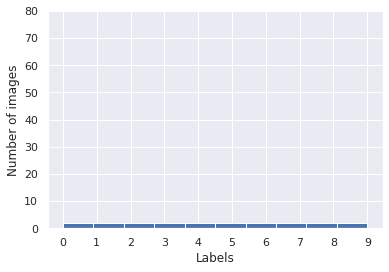

Query  2  
Accuracy with 30 data points:  0.6355000138282776 

Query  3  
Accuracy with 40 data points:  0.6710000038146973 

Query  4  
Accuracy with 50 data points:  0.6837000250816345 

Query  5  
Accuracy with 60 data points:  0.7634000182151794 

Query  6  
Accuracy with 70 data points:  0.7724000215530396 



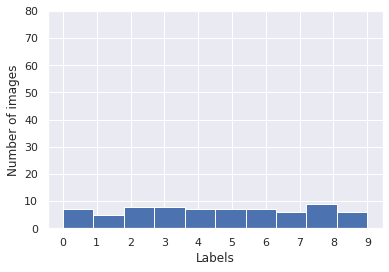

Query  7  
Accuracy with 80 data points:  0.7950999736785889 

Query  8  
Accuracy with 90 data points:  0.8069999814033508 

Query  9  
Accuracy with 100 data points:  0.8180000185966492 

Query  10  
Accuracy with 110 data points:  0.8367000222206116 

Query  11  
Accuracy with 120 data points:  0.8521999716758728 



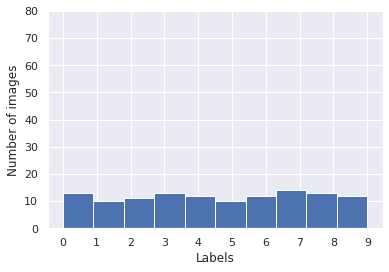

Query  12  
Accuracy with 130 data points:  0.8553000092506409 

Query  13  
Accuracy with 140 data points:  0.8664000034332275 

Query  14  
Accuracy with 150 data points:  0.8673999905586243 

Query  15  
Accuracy with 160 data points:  0.8855000138282776 

Query  16  
Accuracy with 170 data points:  0.886900007724762 



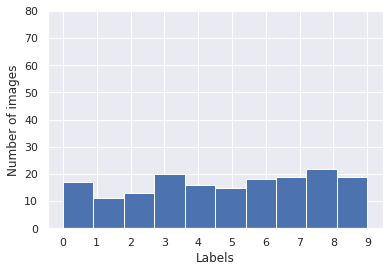

Query  17  
Accuracy with 180 data points:  0.8880000114440918 

Query  18  
Accuracy with 190 data points:  0.8974999785423279 

Query  19  
Accuracy with 200 data points:  0.8945000171661377 

Query  20  
Accuracy with 210 data points:  0.8945000171661377 

Query  21  
Accuracy with 220 data points:  0.8931000232696533 



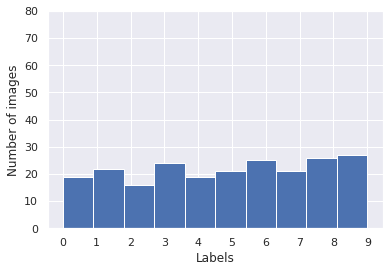

Query  22  
Accuracy with 230 data points:  0.9006999731063843 

Query  23  
Accuracy with 240 data points:  0.9021000266075134 

Query  24  
Accuracy with 250 data points:  0.909500002861023 

Query  25  
Accuracy with 260 data points:  0.9117000102996826 

Query  26  
Accuracy with 270 data points:  0.9136999845504761 



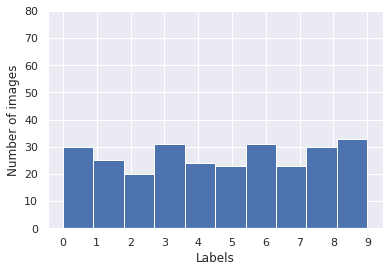

Query  27  
Accuracy with 280 data points:  0.9189000129699707 

Query  28  
Accuracy with 290 data points:  0.9157000184059143 

Query  29  
Accuracy with 300 data points:  0.9124000072479248 

Query  30  
Accuracy with 310 data points:  0.9175999760627747 

Query  31  
Accuracy with 320 data points:  0.9228000044822693 



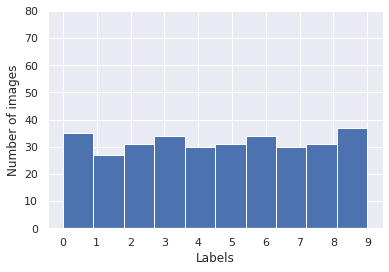

Query  32  
Accuracy with 330 data points:  0.9254000186920166 

Query  33  
Accuracy with 340 data points:  0.927299976348877 

Query  34  
Accuracy with 350 data points:  0.9272000193595886 

Query  35  
Accuracy with 360 data points:  0.9254999756813049 

Query  36  
Accuracy with 370 data points:  0.9258000254631042 



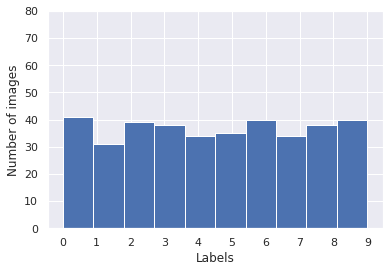

Query  37  
Accuracy with 380 data points:  0.9298999905586243 

Query  38  
Accuracy with 390 data points:  0.9312999844551086 

Query  39  
Accuracy with 400 data points:  0.9244999885559082 

Query  40  
Accuracy with 410 data points:  0.9351000189781189 



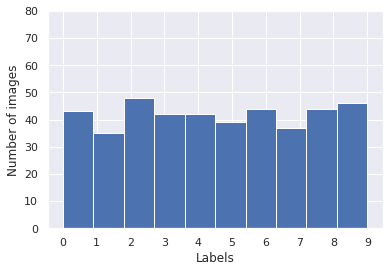

In [5]:
random_hist = active_learner(CNN_MC_with_inference(64,10),
                             images_init,
                             labels_init,
                             images_pool,
                             labels_pool,
                             10,
                             40,
                             5,
                             random,
                             'random')

Query  1  
Accuracy with 20 data points:  0.5828999876976013 



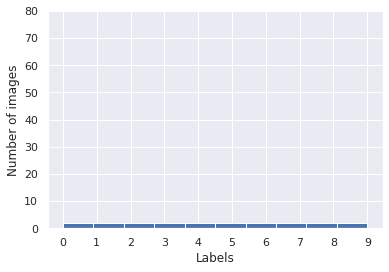

Query  2  
Accuracy with 30 data points:  0.6624000072479248 

Query  3  
Accuracy with 40 data points:  0.6758999824523926 

Query  4  
Accuracy with 50 data points:  0.715399980545044 

Query  5  
Accuracy with 60 data points:  0.7584999799728394 

Query  6  
Accuracy with 70 data points:  0.784500002861023 



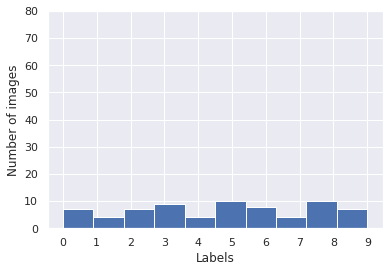

Query  7  
Accuracy with 80 data points:  0.7967000007629395 

Query  8  
Accuracy with 90 data points:  0.819100022315979 

Query  9  
Accuracy with 100 data points:  0.8223999738693237 

Query  10  
Accuracy with 110 data points:  0.8611999750137329 

Query  11  
Accuracy with 120 data points:  0.8801000118255615 



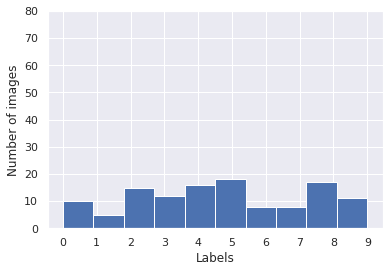

Query  12  
Accuracy with 130 data points:  0.8889999985694885 

Query  13  
Accuracy with 140 data points:  0.8873000144958496 

Query  14  
Accuracy with 150 data points:  0.9061999917030334 

Query  15  
Accuracy with 160 data points:  0.9075000286102295 

Query  16  
Accuracy with 170 data points:  0.9014000296592712 



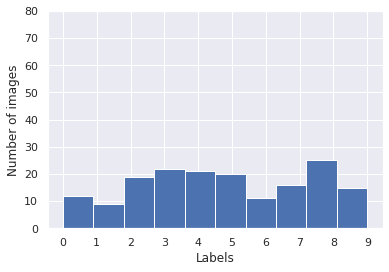

Query  17  
Accuracy with 180 data points:  0.9061999917030334 

Query  18  
Accuracy with 190 data points:  0.9036999940872192 

Query  19  
Accuracy with 200 data points:  0.9225999712944031 

Query  20  
Accuracy with 210 data points:  0.9223999977111816 

Query  21  
Accuracy with 220 data points:  0.9322999715805054 



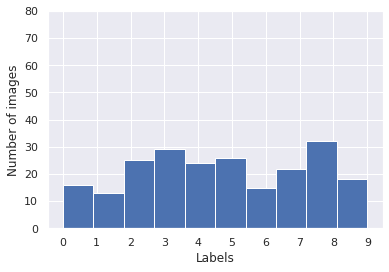

Query  22  
Accuracy with 230 data points:  0.9280999898910522 

Query  23  
Accuracy with 240 data points:  0.9370999932289124 

Query  24  
Accuracy with 250 data points:  0.9383999705314636 

Query  25  
Accuracy with 260 data points:  0.9391000270843506 

Query  26  
Accuracy with 270 data points:  0.9427000284194946 



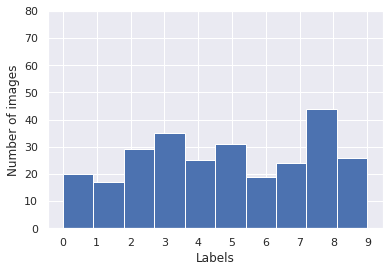

Query  27  
Accuracy with 280 data points:  0.9420999884605408 

Query  28  
Accuracy with 290 data points:  0.9434999823570251 

Query  29  
Accuracy with 300 data points:  0.948199987411499 

Query  30  
Accuracy with 310 data points:  0.9484000205993652 

Query  31  
Accuracy with 320 data points:  0.9538000226020813 



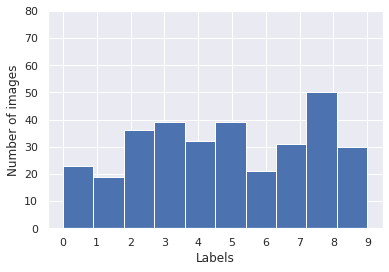

Query  32  
Accuracy with 330 data points:  0.9527000188827515 

Query  33  
Accuracy with 340 data points:  0.9559999704360962 

Query  34  
Accuracy with 350 data points:  0.9553999900817871 

Query  35  
Accuracy with 360 data points:  0.95660001039505 

Query  36  
Accuracy with 370 data points:  0.9563000202178955 



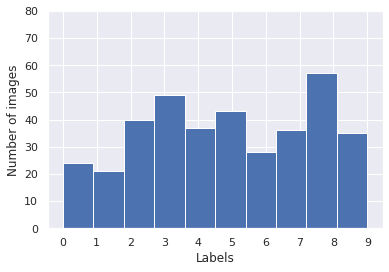

Query  37  
Accuracy with 380 data points:  0.9589999914169312 

Query  38  
Accuracy with 390 data points:  0.9595999717712402 

Query  39  
Accuracy with 400 data points:  0.9610999822616577 

Query  40  
Accuracy with 410 data points:  0.963100016117096 



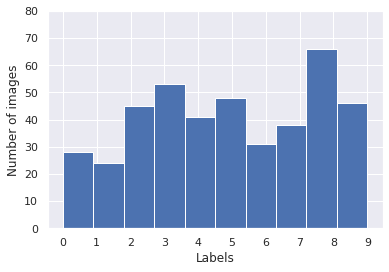

In [6]:
entropy_hist = active_learner(CNN_MC_with_inference(64,10),
                              images_init, labels_init,
                              images_pool, labels_pool,
                              10,
                              40,
                              5,
                              entropy,
                              'entropy')

Query  1  
Accuracy with 20 data points:  0.5964999794960022 



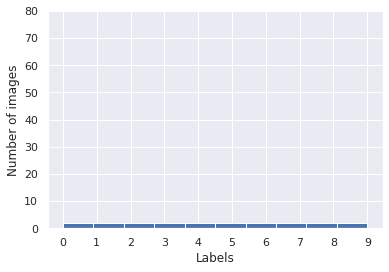

Query  2  
Accuracy with 30 data points:  0.6664999723434448 

Query  3  
Accuracy with 40 data points:  0.7059000134468079 

Query  4  
Accuracy with 50 data points:  0.7049999833106995 

Query  5  
Accuracy with 60 data points:  0.7279999852180481 

Query  6  
Accuracy with 70 data points:  0.7598000168800354 



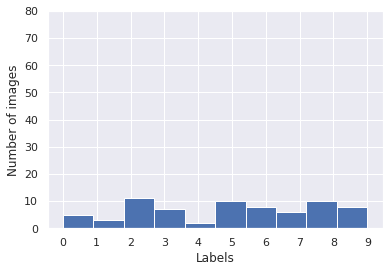

Query  7  
Accuracy with 80 data points:  0.7621999979019165 

Query  8  
Accuracy with 90 data points:  0.770799994468689 

Query  9  
Accuracy with 100 data points:  0.7759000062942505 

Query  10  
Accuracy with 110 data points:  0.8119999766349792 

Query  11  
Accuracy with 120 data points:  0.8486999869346619 



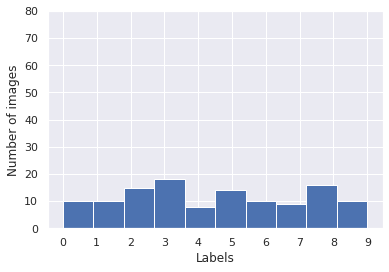

Query  12  
Accuracy with 130 data points:  0.8791999816894531 

Query  13  
Accuracy with 140 data points:  0.8828999996185303 

Query  14  
Accuracy with 150 data points:  0.8852999806404114 

Query  15  
Accuracy with 160 data points:  0.8816999793052673 

Query  16  
Accuracy with 170 data points:  0.9099000096321106 



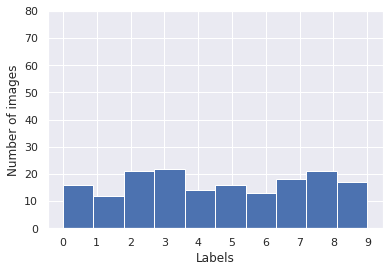

Query  17  
Accuracy with 180 data points:  0.9067000150680542 

Query  18  
Accuracy with 190 data points:  0.9136999845504761 

Query  19  
Accuracy with 200 data points:  0.9158999919891357 

Query  20  
Accuracy with 210 data points:  0.9229999780654907 

Query  21  
Accuracy with 220 data points:  0.9204000234603882 



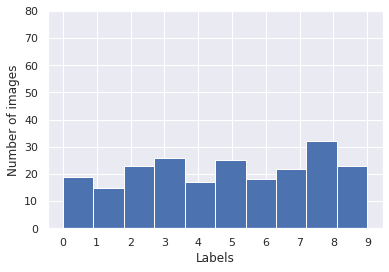

Query  22  
Accuracy with 230 data points:  0.9239000082015991 

Query  23  
Accuracy with 240 data points:  0.933899998664856 

Query  24  
Accuracy with 250 data points:  0.9424999952316284 

Query  25  
Accuracy with 260 data points:  0.9455999732017517 

Query  26  
Accuracy with 270 data points:  0.9448999762535095 



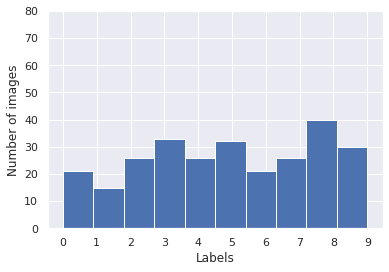

Query  27  
Accuracy with 280 data points:  0.947700023651123 

Query  28  
Accuracy with 290 data points:  0.9491000175476074 

Query  29  
Accuracy with 300 data points:  0.9448999762535095 

Query  30  
Accuracy with 310 data points:  0.9534000158309937 

Query  31  
Accuracy with 320 data points:  0.9524999856948853 



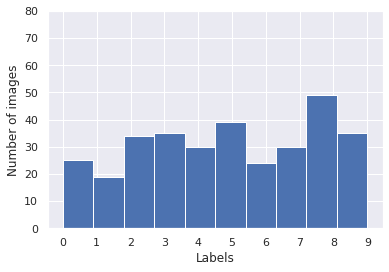

Query  32  
Accuracy with 330 data points:  0.9549999833106995 

Query  33  
Accuracy with 340 data points:  0.9538000226020813 

Query  34  
Accuracy with 350 data points:  0.9556999802589417 

Query  35  
Accuracy with 360 data points:  0.9592000246047974 

Query  36  
Accuracy with 370 data points:  0.9595000147819519 



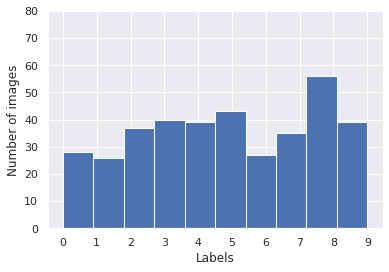

Query  37  
Accuracy with 380 data points:  0.9591000080108643 

Query  38  
Accuracy with 390 data points:  0.9616000056266785 

Query  39  
Accuracy with 400 data points:  0.9634000062942505 

Query  40  
Accuracy with 410 data points:  0.9634000062942505 



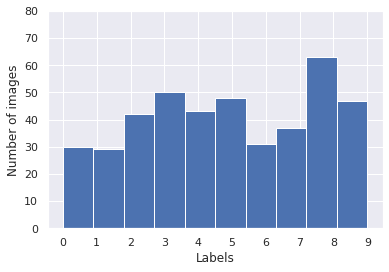

In [7]:
var_ratio_hist = active_learner(CNN_MC_with_inference(64,10),
                                images_init,
                                labels_init,
                                images_pool,
                                labels_pool,
                                10,
                                40,
                                5,
                                var_ratio,
                                'var_ratio')

Query  1  
Accuracy with 20 data points:  0.6037999987602234 



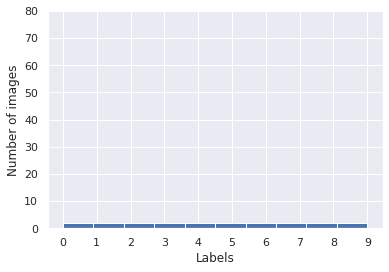

Query  2  
Accuracy with 30 data points:  0.6306999921798706 

Query  3  
Accuracy with 40 data points:  0.6658999919891357 

Query  4  
Accuracy with 50 data points:  0.7057999968528748 

Query  5  
Accuracy with 60 data points:  0.7340999841690063 

Query  6  
Accuracy with 70 data points:  0.7804999947547913 



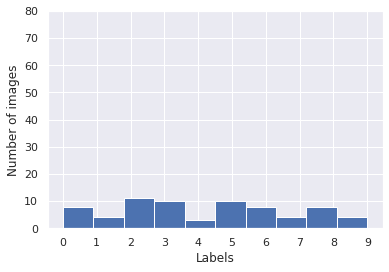

Query  7  
Accuracy with 80 data points:  0.8015000224113464 

Query  8  
Accuracy with 90 data points:  0.8513000011444092 

Query  9  
Accuracy with 100 data points:  0.8489999771118164 

Query  10  
Accuracy with 110 data points:  0.8849999904632568 

Query  11  
Accuracy with 120 data points:  0.8802000284194946 



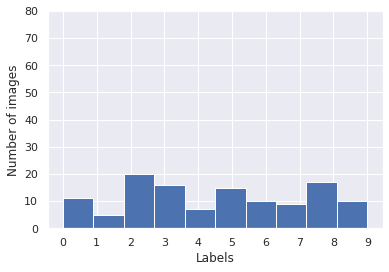

Query  12  
Accuracy with 130 data points:  0.8931000232696533 

Query  13  
Accuracy with 140 data points:  0.892799973487854 

Query  14  
Accuracy with 150 data points:  0.9018999934196472 

Query  15  
Accuracy with 160 data points:  0.909600019454956 

Query  16  
Accuracy with 170 data points:  0.9207000136375427 



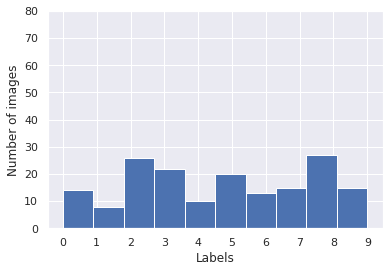

Query  17  
Accuracy with 180 data points:  0.927299976348877 

Query  18  
Accuracy with 190 data points:  0.9312000274658203 

Query  19  
Accuracy with 200 data points:  0.9261000156402588 

Query  20  
Accuracy with 210 data points:  0.9315999746322632 

Query  21  
Accuracy with 220 data points:  0.9399999976158142 



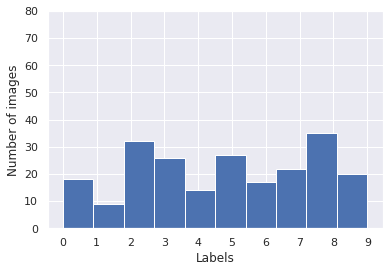

Query  22  
Accuracy with 230 data points:  0.9405999779701233 

Query  23  
Accuracy with 240 data points:  0.944599986076355 

Query  24  
Accuracy with 250 data points:  0.9469000101089478 

Query  25  
Accuracy with 260 data points:  0.9498999714851379 

Query  26  
Accuracy with 270 data points:  0.946399986743927 



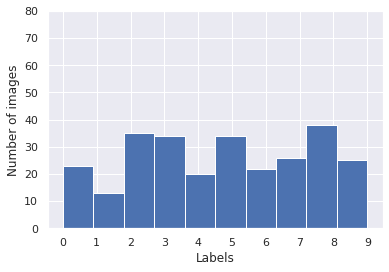

Query  27  
Accuracy with 280 data points:  0.947700023651123 

Query  28  
Accuracy with 290 data points:  0.9488999843597412 

Query  29  
Accuracy with 300 data points:  0.95169997215271 

Query  30  
Accuracy with 310 data points:  0.9534000158309937 

Query  31  
Accuracy with 320 data points:  0.9526000022888184 



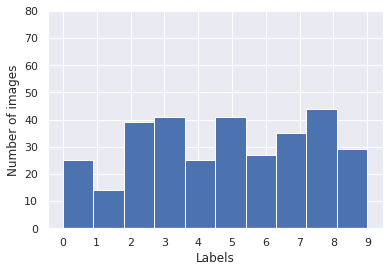

Query  32  
Accuracy with 330 data points:  0.9532999992370605 

Query  33  
Accuracy with 340 data points:  0.9534000158309937 

Query  34  
Accuracy with 350 data points:  0.9575999975204468 

Query  35  
Accuracy with 360 data points:  0.9613000154495239 

Query  36  
Accuracy with 370 data points:  0.9614999890327454 



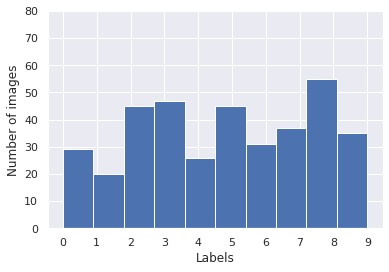

Query  37  
Accuracy with 380 data points:  0.9559999704360962 

Query  38  
Accuracy with 390 data points:  0.9595000147819519 

Query  39  
Accuracy with 400 data points:  0.9592999815940857 

Query  40  
Accuracy with 410 data points:  0.9585999846458435 



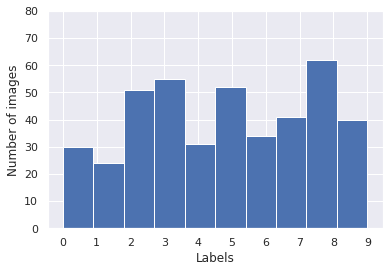

In [8]:
bald_hist = active_learner(CNN_MC_with_inference(64,10),
                                images_init,
                                labels_init,
                                images_pool,
                                labels_pool,
                                10,
                                40,
                                5,
                                bald,
                                'bald')

Query  1  
Accuracy with 20 data points:  0.6086999773979187 



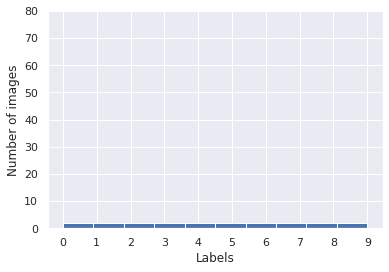

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


Query  2  
Accuracy with 30 data points:  0.6209999918937683 

Query  3  
Accuracy with 40 data points:  0.6640999913215637 

Query  4  
Accuracy with 50 data points:  0.682699978351593 

Query  5  
Accuracy with 60 data points:  0.7049000263214111 

Query  6  
Accuracy with 70 data points:  0.7479000091552734 



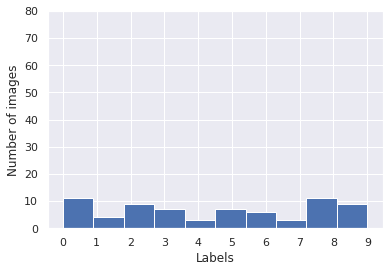

Query  7  
Accuracy with 80 data points:  0.7800999879837036 

Query  8  
Accuracy with 90 data points:  0.796500027179718 

Query  9  
Accuracy with 100 data points:  0.82669997215271 

Query  10  
Accuracy with 110 data points:  0.8371999859809875 

Query  11  
Accuracy with 120 data points:  0.842199981212616 



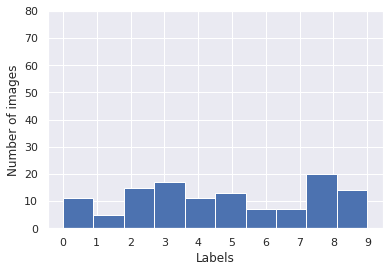

Query  12  
Accuracy with 130 data points:  0.8659999966621399 

Query  13  
Accuracy with 140 data points:  0.8718000054359436 

Query  14  
Accuracy with 150 data points:  0.8657000064849854 

Query  15  
Accuracy with 160 data points:  0.888700008392334 

Query  16  
Accuracy with 170 data points:  0.9122999906539917 



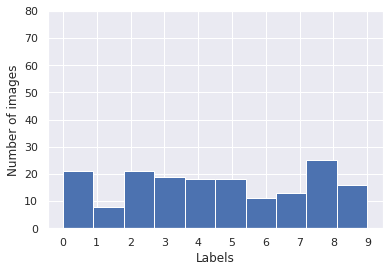

Query  17  
Accuracy with 180 data points:  0.9180999994277954 

Query  18  
Accuracy with 190 data points:  0.9203000068664551 

Query  19  
Accuracy with 200 data points:  0.9319999814033508 

Query  20  
Accuracy with 210 data points:  0.9370999932289124 

Query  21  
Accuracy with 220 data points:  0.9365000128746033 



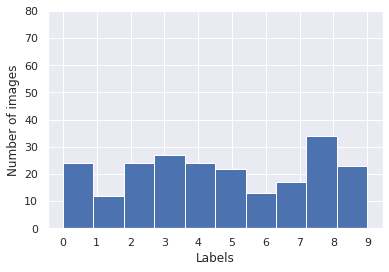

Query  22  
Accuracy with 230 data points:  0.9354000091552734 

Query  23  
Accuracy with 240 data points:  0.9399999976158142 

Query  24  
Accuracy with 250 data points:  0.9437000155448914 

Query  25  
Accuracy with 260 data points:  0.9488000273704529 

Query  26  
Accuracy with 270 data points:  0.9492999911308289 



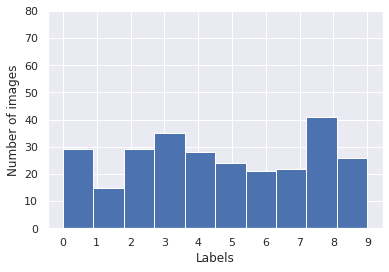

Query  27  
Accuracy with 280 data points:  0.945900022983551 

Query  28  
Accuracy with 290 data points:  0.9474999904632568 

Query  29  
Accuracy with 300 data points:  0.9509999752044678 

Query  30  
Accuracy with 310 data points:  0.9513000249862671 

Query  31  
Accuracy with 320 data points:  0.9541000127792358 



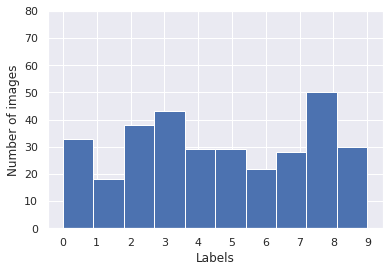

Query  32  
Accuracy with 330 data points:  0.9595999717712402 

Query  33  
Accuracy with 340 data points:  0.9571999907493591 

Query  34  
Accuracy with 350 data points:  0.9595000147819519 

Query  35  
Accuracy with 360 data points:  0.9613999724388123 

Query  36  
Accuracy with 370 data points:  0.960099995136261 



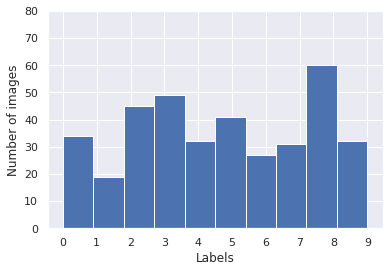

Query  37  
Accuracy with 380 data points:  0.958299994468689 

Query  38  
Accuracy with 390 data points:  0.9616000056266785 

Query  39  
Accuracy with 400 data points:  0.9598000049591064 

Query  40  
Accuracy with 410 data points:  0.9624999761581421 



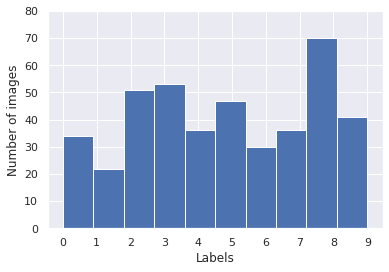

In [11]:
mean_std_hist = active_learner(CNN_MC_with_inference(64,10),
                                images_init,
                                labels_init,
                                images_pool,
                                labels_pool,
                                10,
                                40,
                                5,
                                mean_std,
                                'mean_std')

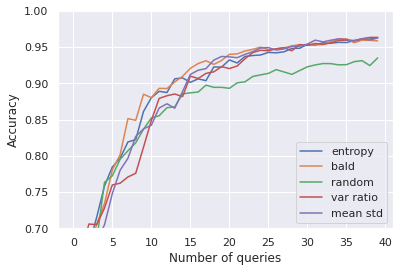

In [12]:
plt.plot(entropy_hist[0], label="entropy")
plt.plot(bald_hist[0], label="bald")
plt.plot(random_hist[0], label="random")
plt.plot(var_ratio_hist[0], label="var ratio")
plt.plot(mean_std_hist[0], label="mean std")
plt.xlabel('Number of queries')
plt.ylabel('Accuracy')
plt.ylim([0.7,1])
plt.savefig('accuracy-all.png')
plt.legend()

Query  1  
Accuracy with 20 data points:  0.5526999831199646 



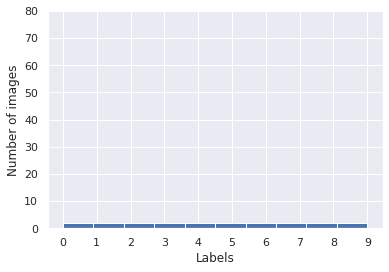

Query  2  
Accuracy with 30 data points:  0.6449999809265137 

Query  3  
Accuracy with 40 data points:  0.6851999759674072 

Query  4  
Accuracy with 50 data points:  0.7369999885559082 

Query  5  
Accuracy with 60 data points:  0.7700999975204468 

Query  6  
Accuracy with 70 data points:  0.7875000238418579 



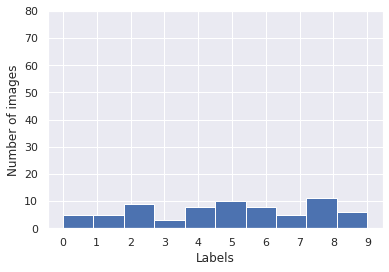

Query  7  
Accuracy with 80 data points:  0.8325999975204468 

Query  8  
Accuracy with 90 data points:  0.8562999963760376 

Query  9  
Accuracy with 100 data points:  0.8673999905586243 

Query  10  
Accuracy with 110 data points:  0.8895000219345093 

Query  11  
Accuracy with 120 data points:  0.895799994468689 



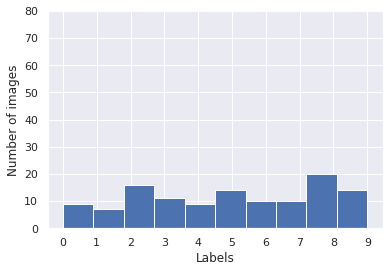

Query  12  
Accuracy with 130 data points:  0.9021000266075134 

Query  13  
Accuracy with 140 data points:  0.9053000211715698 

Query  14  
Accuracy with 150 data points:  0.9128999710083008 

Query  15  
Accuracy with 160 data points:  0.9132000207901001 

Query  16  
Accuracy with 170 data points:  0.9117000102996826 



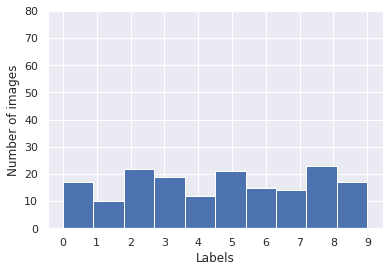

Query  17  
Accuracy with 180 data points:  0.9147999882698059 

Query  18  
Accuracy with 190 data points:  0.925599992275238 

Query  19  
Accuracy with 200 data points:  0.9308000206947327 

Query  20  
Accuracy with 210 data points:  0.9316999912261963 

Query  21  
Accuracy with 220 data points:  0.9327999949455261 



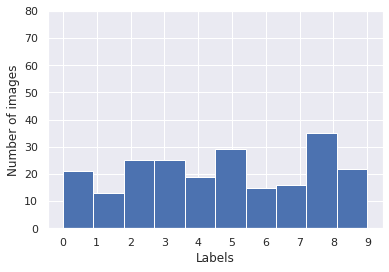

Query  22  
Accuracy with 230 data points:  0.9383999705314636 

Query  23  
Accuracy with 240 data points:  0.9433000087738037 

Query  24  
Accuracy with 250 data points:  0.9430000185966492 

Query  25  
Accuracy with 260 data points:  0.9455999732017517 

Query  26  
Accuracy with 270 data points:  0.9453999996185303 



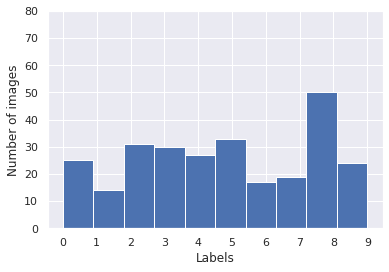

Query  27  
Accuracy with 280 data points:  0.9472000002861023 

Query  28  
Accuracy with 290 data points:  0.9449999928474426 

Query  29  
Accuracy with 300 data points:  0.9415000081062317 

Query  30  
Accuracy with 310 data points:  0.9453999996185303 

Query  31  
Accuracy with 320 data points:  0.9473999738693237 



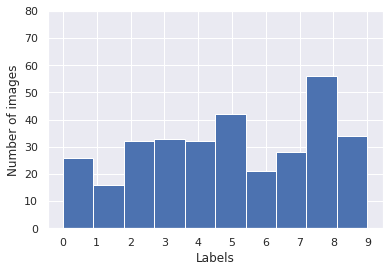

Query  32  
Accuracy with 330 data points:  0.9472000002861023 

Query  33  
Accuracy with 340 data points:  0.9462000131607056 

Query  34  
Accuracy with 350 data points:  0.9513000249862671 

Query  35  
Accuracy with 360 data points:  0.9480999708175659 

Query  36  
Accuracy with 370 data points:  0.9510999917984009 



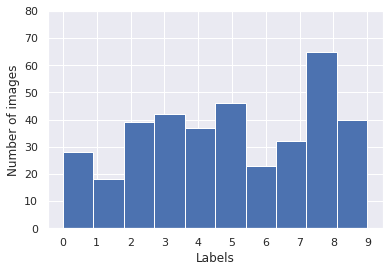

Query  37  
Accuracy with 380 data points:  0.9521999955177307 

Query  38  
Accuracy with 390 data points:  0.957099974155426 

Query  39  
Accuracy with 400 data points:  0.9589999914169312 

Query  40  
Accuracy with 410 data points:  0.958899974822998 



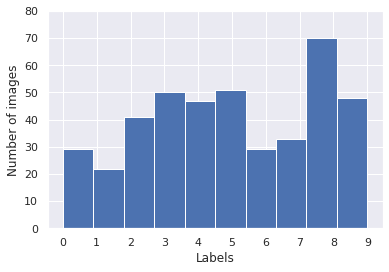

In [112]:
bald_hist_10 = active_learner(CNN_MC_with_inference(64,10,n_forward_passes=10),
                                images_init,
                                labels_init,
                                images_pool,
                                labels_pool,
                                10,
                                40,
                                10,
                                bald,
                                'bald10')

Query  1  
Accuracy with 20 data points:  0.5702000260353088 



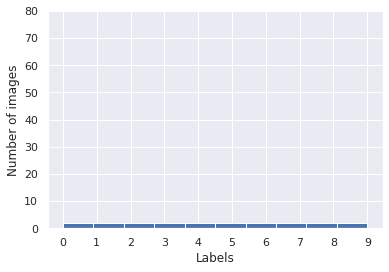

Query  2  
Accuracy with 30 data points:  0.6383000016212463 

Query  3  
Accuracy with 40 data points:  0.6987000107765198 

Query  4  
Accuracy with 50 data points:  0.7576000094413757 

Query  5  
Accuracy with 60 data points:  0.8029999732971191 

Query  6  
Accuracy with 70 data points:  0.828000009059906 



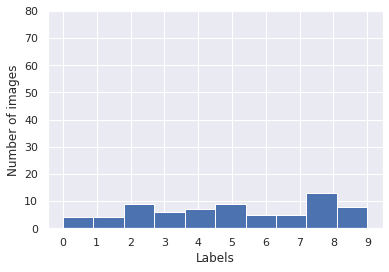

Query  7  
Accuracy with 80 data points:  0.8367999792098999 

Query  8  
Accuracy with 90 data points:  0.8575999736785889 

Query  9  
Accuracy with 100 data points:  0.8679999709129333 

Query  10  
Accuracy with 110 data points:  0.8774999976158142 

Query  11  
Accuracy with 120 data points:  0.890500009059906 



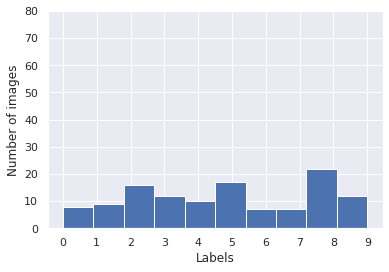

Query  12  
Accuracy with 130 data points:  0.8930000066757202 

Query  13  
Accuracy with 140 data points:  0.8967999815940857 

Query  14  
Accuracy with 150 data points:  0.907800018787384 

Query  15  
Accuracy with 160 data points:  0.9122999906539917 

Query  16  
Accuracy with 170 data points:  0.913100004196167 



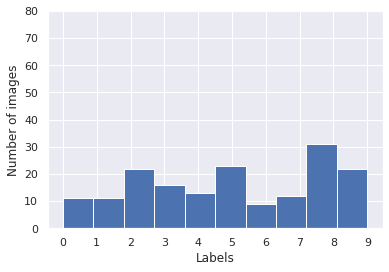

Query  17  
Accuracy with 180 data points:  0.9186000227928162 

Query  18  
Accuracy with 190 data points:  0.9269000291824341 

Query  19  
Accuracy with 200 data points:  0.9322999715805054 

Query  20  
Accuracy with 210 data points:  0.9352999925613403 

Query  21  
Accuracy with 220 data points:  0.9355000257492065 



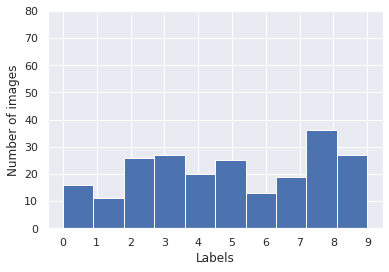

Query  22  
Accuracy with 230 data points:  0.9417999982833862 

Query  23  
Accuracy with 240 data points:  0.9430000185966492 

Query  24  
Accuracy with 250 data points:  0.9459999799728394 

Query  25  
Accuracy with 260 data points:  0.9483000040054321 

Query  26  
Accuracy with 270 data points:  0.9524000287055969 



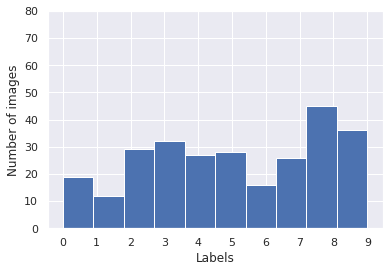

Query  27  
Accuracy with 280 data points:  0.951200008392334 

Query  28  
Accuracy with 290 data points:  0.9546999931335449 

Query  29  
Accuracy with 300 data points:  0.9553999900817871 

Query  30  
Accuracy with 310 data points:  0.9562000036239624 

Query  31  
Accuracy with 320 data points:  0.954800009727478 



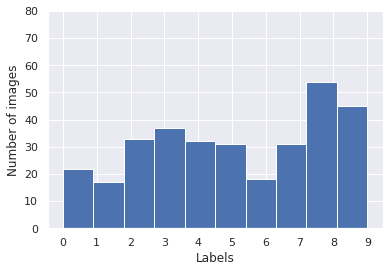

Query  32  
Accuracy with 330 data points:  0.9574999809265137 

Query  33  
Accuracy with 340 data points:  0.960099995136261 

Query  34  
Accuracy with 350 data points:  0.9591000080108643 

Query  35  
Accuracy with 360 data points:  0.9584000110626221 

Query  36  
Accuracy with 370 data points:  0.9641000032424927 



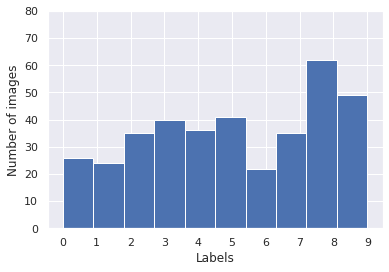

Query  37  
Accuracy with 380 data points:  0.9596999883651733 

Query  38  
Accuracy with 390 data points:  0.9632999897003174 

Query  39  
Accuracy with 400 data points:  0.9631999731063843 

Query  40  
Accuracy with 410 data points:  0.963100016117096 



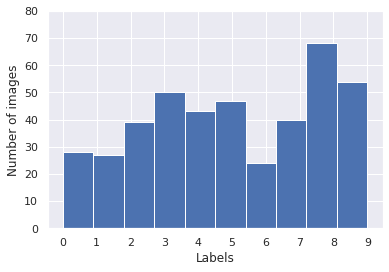

In [114]:
bald_hist_15 = active_learner(CNN_MC_with_inference(64,10,n_forward_passes=15),
                                images_init,
                                labels_init,
                                images_pool,
                                labels_pool,
                                10,
                                40,
                                15,
                                bald,
                                'bald15')

Query  1  
Accuracy with 20 data points:  0.5720999836921692 



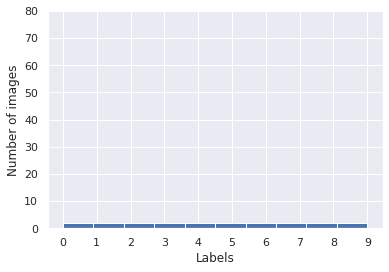

Query  2  
Accuracy with 30 data points:  0.6481000185012817 

Query  3  
Accuracy with 40 data points:  0.73580002784729 

Query  4  
Accuracy with 50 data points:  0.7784000039100647 

Query  5  
Accuracy with 60 data points:  0.7623999714851379 

Query  6  
Accuracy with 70 data points:  0.7814000248908997 



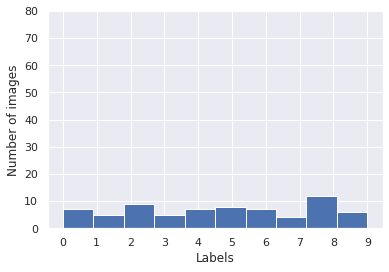

Query  7  
Accuracy with 80 data points:  0.8176000118255615 

Query  8  
Accuracy with 90 data points:  0.8331999778747559 

Query  9  
Accuracy with 100 data points:  0.849399983882904 

Query  10  
Accuracy with 110 data points:  0.866100013256073 

Query  11  
Accuracy with 120 data points:  0.864300012588501 



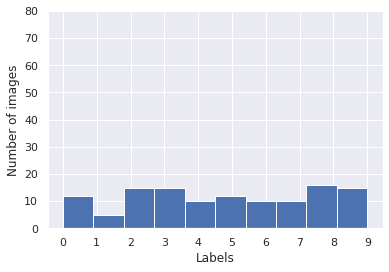

Query  12  
Accuracy with 130 data points:  0.8824999928474426 

Query  13  
Accuracy with 140 data points:  0.8946999907493591 

Query  14  
Accuracy with 150 data points:  0.906499981880188 

Query  15  
Accuracy with 160 data points:  0.9140999913215637 

Query  16  
Accuracy with 170 data points:  0.9225000143051147 



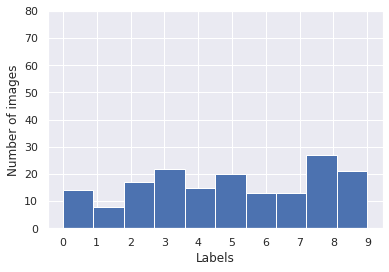

Query  17  
Accuracy with 180 data points:  0.9212999939918518 

Query  18  
Accuracy with 190 data points:  0.9258999824523926 

Query  19  
Accuracy with 200 data points:  0.9276999831199646 

Query  20  
Accuracy with 210 data points:  0.9266999959945679 

Query  21  
Accuracy with 220 data points:  0.9348999857902527 



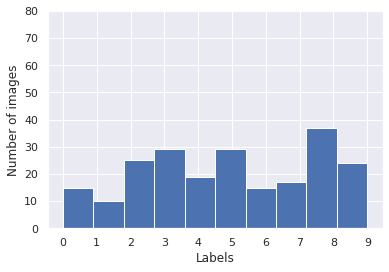

Query  22  
Accuracy with 230 data points:  0.9334999918937683 

Query  23  
Accuracy with 240 data points:  0.9370999932289124 

Query  24  
Accuracy with 250 data points:  0.9361000061035156 

Query  25  
Accuracy with 260 data points:  0.9390000104904175 

Query  26  
Accuracy with 270 data points:  0.9398999810218811 



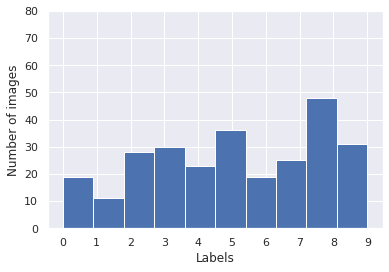

Query  27  
Accuracy with 280 data points:  0.9435999989509583 

Query  28  
Accuracy with 290 data points:  0.9422000050544739 

Query  29  
Accuracy with 300 data points:  0.9434000253677368 

Query  30  
Accuracy with 310 data points:  0.9467999935150146 

Query  31  
Accuracy with 320 data points:  0.9485999941825867 



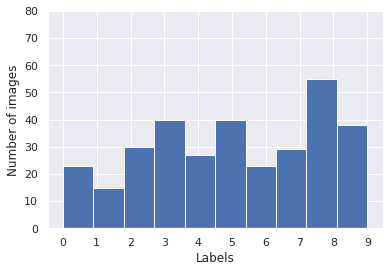

Query  32  
Accuracy with 330 data points:  0.9531999826431274 

Query  33  
Accuracy with 340 data points:  0.9509999752044678 

Query  34  
Accuracy with 350 data points:  0.9542999863624573 

Query  35  
Accuracy with 360 data points:  0.9562000036239624 

Query  36  
Accuracy with 370 data points:  0.9560999870300293 



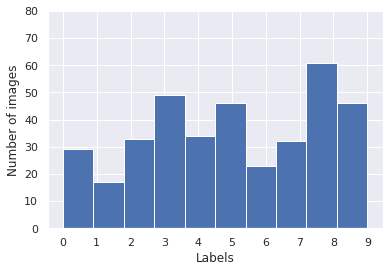

Query  37  
Accuracy with 380 data points:  0.9605000019073486 

Query  38  
Accuracy with 390 data points:  0.9595000147819519 

Query  39  
Accuracy with 400 data points:  0.9570000171661377 

Query  40  
Accuracy with 410 data points:  0.9573000073432922 



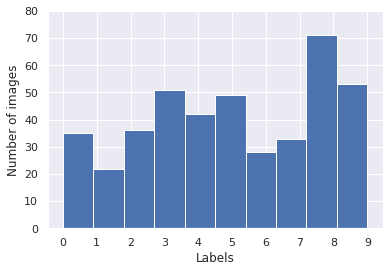

In [130]:
bald_hist_20 = active_learner(CNN_MC_with_inference(64,10,n_forward_passes=20),
                                images_init,
                                labels_init,
                                images_pool,
                                labels_pool,
                                10,
                                40,
                                20,
                                bald,
                                'bald20')

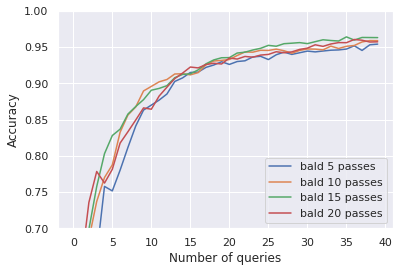

In [131]:
plt.plot(bald_hist, label="bald 5 passes")
plt.plot(bald_hist_10, label="bald 10 passes")
plt.plot(bald_hist_15, label="bald 15 passes")
plt.plot(bald_hist_20, label="bald 20 passes")
plt.xlabel('Number of queries')
plt.ylabel('Accuracy')
plt.ylim([0.7,1])
plt.savefig('accuracy-bald-different-forward-passes.png')
plt.legend()